# DC GAN for Face Generation on Celebrity Dataset

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os
import gdown
from zipfile import ZipFile

## Preparing Dataset

In [4]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

## Load the Dataset

In [10]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root="celeba_gan", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

## Visualize the image

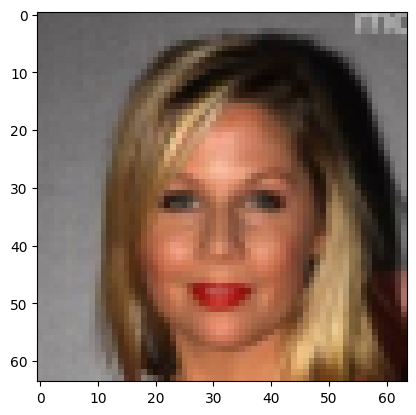

In [17]:
for images, _ in dataloader:
    img = images[0]
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    break

## Generator Network

In [18]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## Discriminator Network

In [19]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


## Initialize the Netwrok

In [20]:
nz = 100
ngf = 64
ndf = 64
nc = 3
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)


criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


## Training the Generator and Discriminator

In [22]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), 1.0, device=device, dtype=torch.float)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label = torch.full_like(output, 0.0, device=device, dtype=torch.float)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()


        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            fake = netG(torch.randn(64, nz, 1, 1, device=device))
            save_image(fake.detach(), 'celeba_gan/fake_samples_epoch_%03d.png' % (epoch+1), normalize=True)

[0/10][0/1583]	Loss_D: 1.6655	Loss_G: 5.4255	D(x): 0.6256	D(G(z)): 0.5897 / 0.0074
[0/10][50/1583]	Loss_D: 0.4190	Loss_G: 27.3573	D(x): 0.8487	D(G(z)): 0.0000 / 0.0000


KeyboardInterrupt: 

## Save models

In [ ]:
torch.save(netG.state_dict(), 'celeba_gan/netG.pth')
torch.save(netD.state_dict(), 'celeba_gan/netD.pth')